## Cross Validation con XGBoost

In [1]:
import pandas as pd

dataset_work_3 = pd.read_csv('D:\DataSet\dataset_work_transformed.csv')
x = dataset_work_3.iloc[:,:-1]
y = dataset_work_3.iloc[:,-1].values
dataset_work_3.shape

(6435823, 16)

C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [12:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [12:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validación Cruzada (Acuracidad) - Media: 0.8190, Desviación Estándar: 0.0002


C:\Users\hrqui\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [12:57:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados en el Conjunto de Prueba:
Accuracy: 0.8203
Precision: 0.7623
Recall: 0.8307
F1-Score: 0.7950
AUC (Prueba): 0.9197
Reporte de Clasificación (XGBoost):
              precision    recall  f1-score   support

           0       0.87      0.81      0.84   1120839
           1       0.76      0.83      0.80    809908

    accuracy                           0.82   1930747
   macro avg       0.82      0.82      0.82   1930747
weighted avg       0.82      0.82      0.82   1930747



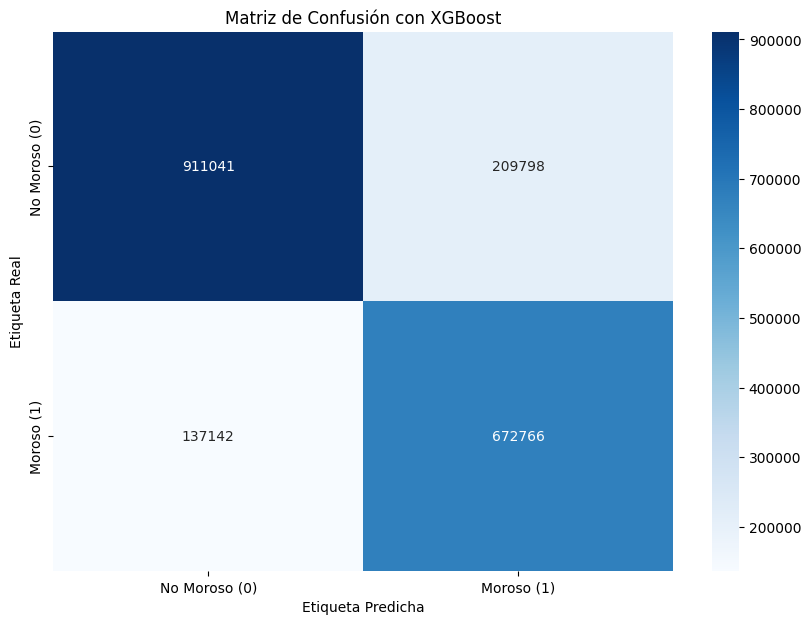

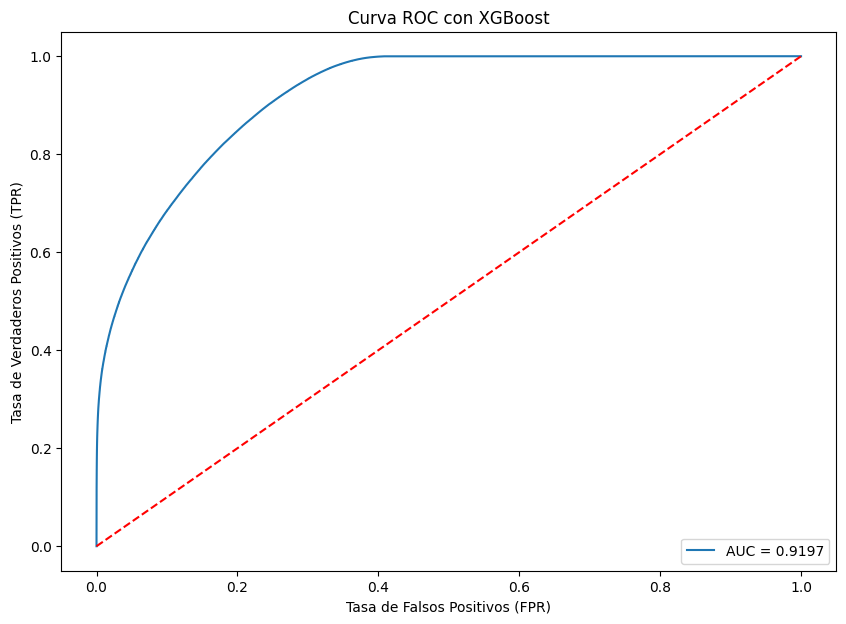

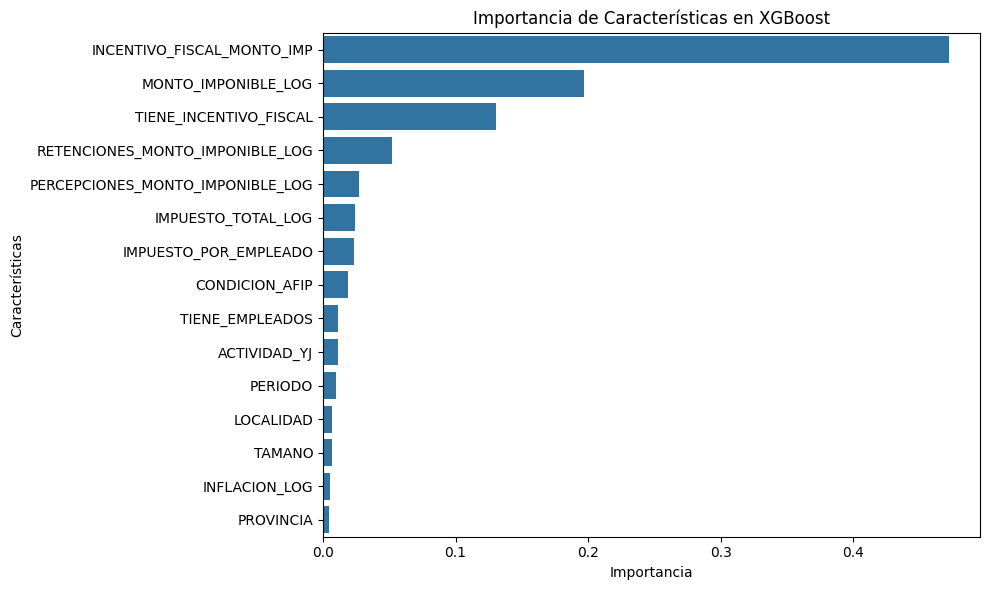

El tiempo total de ejecución fue de 5 minutos y 13.89 segundos.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Registro del tiempo de inicio
start_time = time.time()

# Definir las características y la variable objetivo
X = dataset_work_3.drop(columns=["MOROSIDAD"])
y = dataset_work_3["MOROSIDAD"]

# Separar el dataset en conjunto de entrenamiento (30%) y test (70%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hiperparámetros óptimos para XGBoost
optimal_params = {
    'subsample': 0.8,
    'n_estimators': 300,
    'min_child_weight': 1,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'colsample_bytree': 0.6,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}


# Crear el modelo XGBoost con los parámetros óptimos
clf_xgb = XGBClassifier(**optimal_params)

# Realizar la validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(clf_xgb, X_train, y_train, cv=2, scoring='accuracy')
print(f"Validación Cruzada (Acuracidad) - Media: {cv_scores.mean():.4f}, Desviación Estándar: {cv_scores.std():.4f}")

# Entrenar el modelo con los datos de entrenamiento
clf_xgb.fit(X_train, y_train)

# Predecir en los datos de prueba
y_pred_xgb = clf_xgb.predict(X_test)
probs_xgb = clf_xgb.predict_proba(X_test)
preds_xgb = probs_xgb[:, 1]

# Calcular métricas de evaluación en el conjunto de prueba
fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_xgb)
roc_auc_test = auc(fpr_test, tpr_test)

print("Resultados en el Conjunto de Prueba:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"AUC (Prueba): {roc_auc_test:.4f}")

# Reporte de Clasificación
print("Reporte de Clasificación (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# Matriz de Confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['No Moroso (0)', 'Moroso (1)'], yticklabels=['No Moroso (0)', 'Moroso (1)'])
plt.title("Matriz de Confusión con XGBoost")
plt.ylabel("Etiqueta Real")
plt.xlabel("Etiqueta Predicha")
plt.show()

# Curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.title('Curva ROC con XGBoost')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

# Importancia de Características (corregido)
feature_importance = clf_xgb.feature_importances_
feature_names = X.columns

# Crear un DataFrame para organizar las importancias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Graficar la importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', orient='h')
plt.title('Importancia de Características en XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

# Medir el tiempo de finalización y calcular el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time

# Convertir a minutos y segundos
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f"El tiempo total de ejecución fue de {int(minutes)} minutos y {seconds:.2f} segundos.")
